In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [31]:
def generate_synthetic_data(samples=1000):
    np.random.seed(42)
    data = {
        'UTS_MPa': np.random.uniform(500, 1000, samples),
        'Yield_Strength_MPa': np.random.uniform(300, 800, samples),
        'Hardness_Brinell': np.random.uniform(150, 400, samples),
        'Endurance_Limit_MPa': np.random.uniform(200, 500, samples),
        'Fillet_Radius_mm': np.random.uniform(2, 10, samples),
        'Journal_Diameter_mm': np.random.uniform(40, 100, samples),
        'Shaft_Thickness_mm': np.random.uniform(10, 30, samples),
        'Max_Torque_Nm': np.random.uniform(200, 800, samples),
        'RPM': np.random.uniform(1000, 6000, samples),
        'Mean_Stress_MPa': np.random.uniform(50, 200, samples),
        'Stress_Amplitude_MPa': np.random.uniform(100, 400, samples),
        'Surface_Finish_Ra': np.random.uniform(0.1, 3.2, samples),
        'Residual_Stress_MPa': np.random.uniform(-200, 200, samples),
        'Fatigue_Life_Cycles': np.random.randint(1e5, 1e7, samples)
    }
    return pd.DataFrame(data)
df = generate_synthetic_data()
df.head()

,UTS_MPa,Yield_Strength_MPa,Hardness_Brinell,Endurance_Limit_MPa,Fillet_Radius_mm,Journal_Diameter_mm,Shaft_Thickness_mm,Max_Torque_Nm,RPM,Mean_Stress_MPa,Stress_Amplitude_MPa,Surface_Finish_Ra,Residual_Stress_MPa,Fatigue_Life_Cycles
0,687.270059,392.566464,215.426421,401.810898,6.575967,63.618131,22.965139,223.279673,4601.339620,187.036702,212.092246,1.752395,61.722529,7235590
1,975.357153,570.950474,211.744700,439.004419,8.443459,68.406140,13.447727,312.063517,4436.415022,128.804072,199.873629,0.527486,-167.986972,6748561
2,865.996971,736.472918,376.563645,275.140370,8.081287,91.272844,27.447891,698.747483,1478.770993,158.736541,152.846174,1.932853,-103.068075,2702562
3,799.329242,666.112443,212.386550,387.462230,3.231199,60.400263,22.262325,660.061014,5612.862025,115.407245,282.180001,1.075835,109.471739,6499177
4,578.009320,703.280574,217.987432,371.523795,3.193996,92.178981,13.144078,410.385615,3842.361011,144.505187,242.987248,0.262281,11.474341,9883545


In [32]:
def preprocess_data(df):
    X = df.drop('Fatigue_Life_Cycles', axis=1)
    y = df['Fatigue_Life_Cycles']
    y_log = np.log10(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler
X_train, X_test, y_train, y_test, scaler = preprocess_data(df)

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
def train_xgboost_fast(X_train, y_train, n_iter=50, cv=3, early_stopping_rounds=10):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=early_stopping_rounds,
        eval_metric='rmse'
    )
    param_dist = {
        'n_estimators': randint(100, 300),
        'max_depth': randint(3, 7),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.8, 0.2),
        'colsample_bytree': uniform(0.8, 0.2),
        'gamma': uniform(0, 0.5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1)
    }
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='neg_mean_squared_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    random_search.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train)],
        verbose=False
    )
    print(f"Best Params: {random_search.best_params_}")
    return random_search.best_estimator_
model_fast = train_xgboost_fast(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Params: {'colsample_bytree': np.float64(0.9907857154005175), 'gamma': np.float64(0.45743219511022426), 'learning_rate': np.float64(0.08403174005108888), 'max_depth': 3, 'n_estimators': 136, 'reg_alpha': np.float64(0.9283185625877254), 'reg_lambda': np.float64(0.42818414831731433), 'subsample': np.float64(0.993330963808734)}


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Params: {'colsample_bytree': np.float64(0.9907857154005175), 'gamma': np.float64(0.45743219511022426), 'learning_rate': np.float64(0.08403174005108888), 'max_depth': 3, 'n_estimators': 136, 'reg_alpha': np.float64(0.9283185625877254), 'reg_lambda': np.float64(0.42818414831731433), 'subsample': np.float64(0.993330963808734)}
RMSE: 0.3756
R² Score: -0.0404


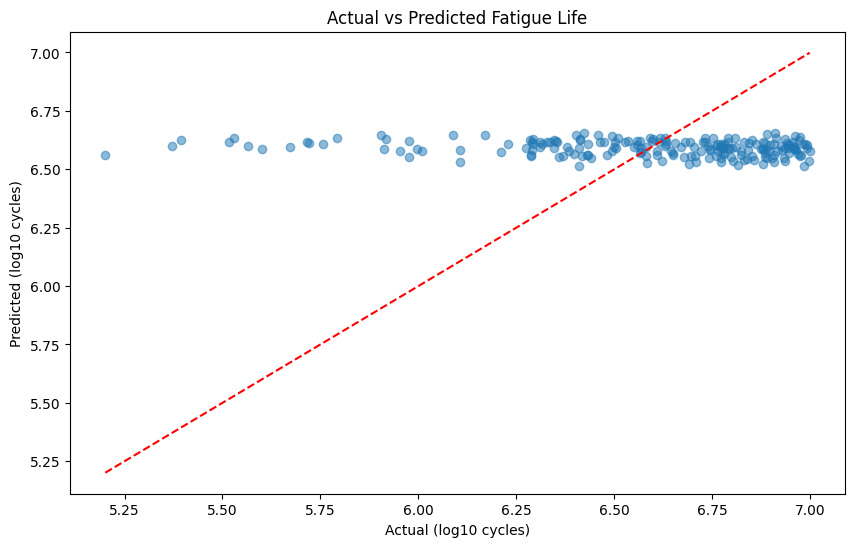

In [34]:
df = generate_synthetic_data()
X_train, X_test, y_train, y_test, scaler = preprocess_data(df)
model = train_xgboost_fast(X_train, y_train)
evaluate_model(model, X_test, y_test)

MSE: 0.1411
R² Score: -0.0404


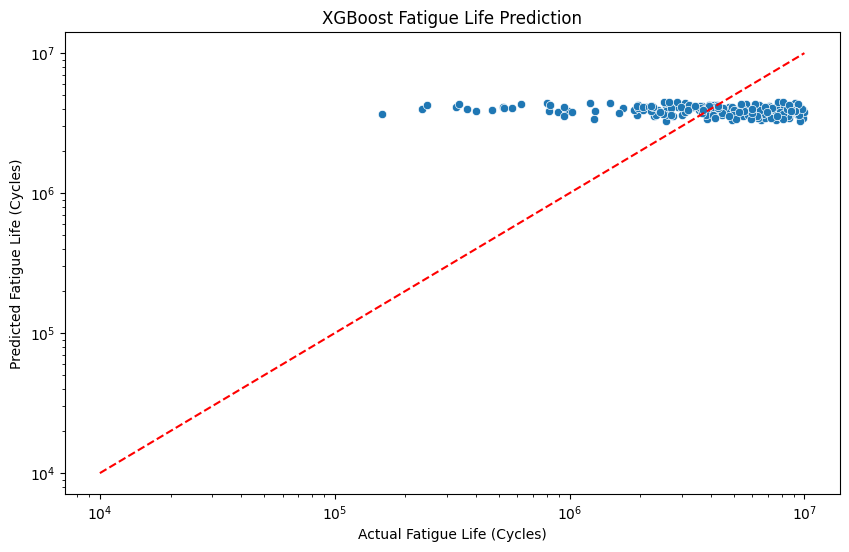

In [35]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=10**y_test, y=10**y_pred)
    plt.xlabel('Actual Fatigue Life (Cycles)')
    plt.ylabel('Predicted Fatigue Life (Cycles)')
    plt.title('XGBoost Fatigue Life Prediction')
    plt.plot([1e4, 1e7], [1e4, 1e7], 'r--')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
evaluate_model(model, X_test, y_test)

In [36]:
def predict_fatigue_life(model, scaler, new_data):
    new_data_scaled = scaler.transform(new_data)
    log_pred = model.predict(new_data_scaled)
    pred_cycles = 10**log_pred
    return pred_cycles
new_design = pd.DataFrame({
    'UTS_MPa': [800],
    'Yield_Strength_MPa': [600],
    'Hardness_Brinell': [300],
    'Endurance_Limit_MPa': [350],
    'Fillet_Radius_mm': [5],
    'Journal_Diameter_mm': [70],
    'Shaft_Thickness_mm': [20],
    'Max_Torque_Nm': [500],
    'RPM': [4000],
    'Mean_Stress_MPa': [150],
    'Stress_Amplitude_MPa': [300],
    'Surface_Finish_Ra': [0.8],
    'Residual_Stress_MPa': [-100]
})
predicted_life = predict_fatigue_life(model, scaler, new_design)
print(f"Predicted Fatigue Life: {predicted_life[0]:.2f} cycles")

Predicted Fatigue Life: 3862006.25 cycles


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
import optuna
from functools import partial

In [48]:
def generate_synthetic_data(samples=5000):
    np.random.seed(42)
    data = {
        'UTS_MPa': np.random.uniform(500, 1000, samples),
        'Yield_Strength_MPa': np.random.uniform(300, 800, samples),
        'Hardness_Brinell': np.random.uniform(150, 400, samples),
        'Endurance_Limit_MPa': np.random.uniform(200, 500, samples),
        'Fillet_Radius_mm': np.random.uniform(2, 10, samples),
        'Journal_Diameter_mm': np.random.uniform(40, 100, samples),
        'Shaft_Thickness_mm': np.random.uniform(10, 30, samples),
        'Max_Torque_Nm': np.random.uniform(200, 800, samples),
        'RPM': np.random.uniform(1000, 6000, samples),
        'Mean_Stress_MPa': np.random.uniform(50, 200, samples),
        'Stress_Amplitude_MPa': np.random.uniform(100, 400, samples),
        'Surface_Finish_Ra': np.random.uniform(0.1, 3.2, samples),
        'Residual_Stress_MPa': np.random.uniform(-200, 200, samples),
        'Fatigue_Life_Cycles': np.random.randint(1e5, 1e7, samples)
    }
    return pd.DataFrame(data)

In [49]:
def add_engineered_features(df):
    df['Kt'] = 1 + 2 * (df['Fillet_Radius_mm'] / df['Journal_Diameter_mm'])**(-0.326)
    df['Goodman_Parameter'] = df['Stress_Amplitude_MPa'] / (
        df['Endurance_Limit_MPa'] * (1 - df['Mean_Stress_MPa'] / df['UTS_MPa'])
    )
    df['Load_Interaction'] = (df['Max_Torque_Nm'] * df['RPM']) / (df['Journal_Diameter_mm']**3)
    df['Surface_Modifier'] = 1 - 0.22 * (np.log10(df['Surface_Finish_Ra'])**0.64)
    return df

In [50]:
def train_xgboost_model(X_train, y_train):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist',
        random_state=42,
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1
    )
    model.fit(X_train, y_train)
    return model

In [51]:
def optimize_hyperparameters(X_train, y_train):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 9),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 0.5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'tree_method': 'hist'
        }
        model = xgb.XGBRegressor(**params, random_state=42)
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        scores = []
        for train_idx, val_idx in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
            try:
                model.fit(X_train_fold, y_train_fold)
                score = -mean_squared_error(y_val_fold, model.predict(X_val_fold))
                scores.append(score)
            except:
                continue
        return np.mean(scores) if len(scores) > 0 else float('-inf')
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20, show_progress_bar=True)
    return study.best_params

In [52]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual (log10 cycles)')
    plt.ylabel('Predicted (log10 cycles)')
    plt.title('Actual vs Predicted Fatigue Life')
    plt.show()

Training initial model...
RMSE: 0.3956
R² Score: -0.0906


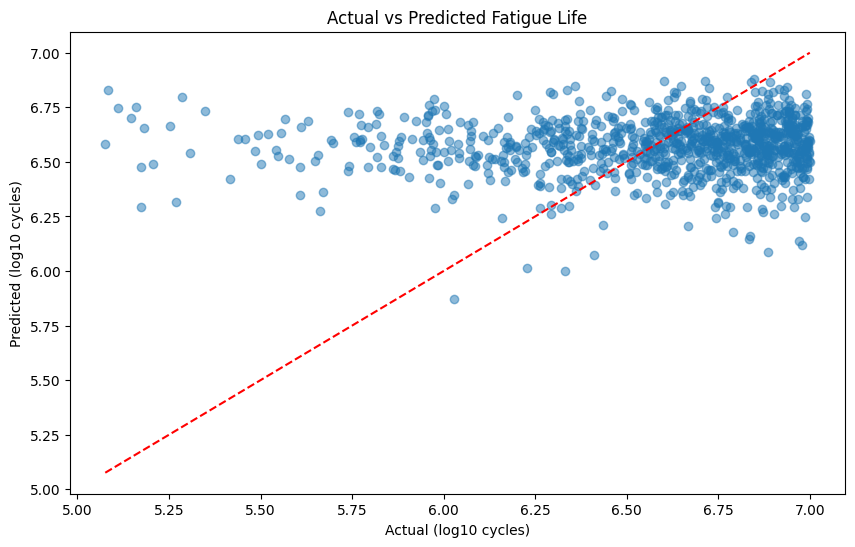

[I 2025-04-27 15:13:36,657] A new study created in memory with name: no-name-fa7f5e5c-288c-4a29-abe5-14427af88747



Optimizing hyperparameters...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-04-27 15:13:39,960] Trial 0 finished with value: -0.15815014316907872 and parameters: {'n_estimators': 163, 'max_depth': 5, 'learning_rate': 0.11541501069435739, 'subsample': 0.9296283603319777, 'colsample_bytree': 0.7357527840322349, 'gamma': 0.020660494875643032, 'reg_alpha': 3.4531046820872504, 'reg_lambda': 5.56724023627128}. Best is trial 0 with value: -0.15815014316907872.
[I 2025-04-27 15:13:42,335] Trial 1 finished with value: -0.15027064277757166 and parameters: {'n_estimators': 173, 'max_depth': 8, 'learning_rate': 0.023762248030171608, 'subsample': 0.8419635596266102, 'colsample_bytree': 0.6560629316461503, 'gamma': 0.1917916873803725, 'reg_alpha': 2.4360854851585954, 'reg_lambda': 3.714795759664554}. Best is trial 1 with value: -0.15027064277757166.
[I 2025-04-27 15:13:46,478] Trial 2 finished with value: -0.15085750850000015 and parameters: {'n_estimators': 213, 'max_depth': 7, 'learning_rate': 0.01386583795528777, 'subsample': 0.7901450569454109, 'colsample_bytree

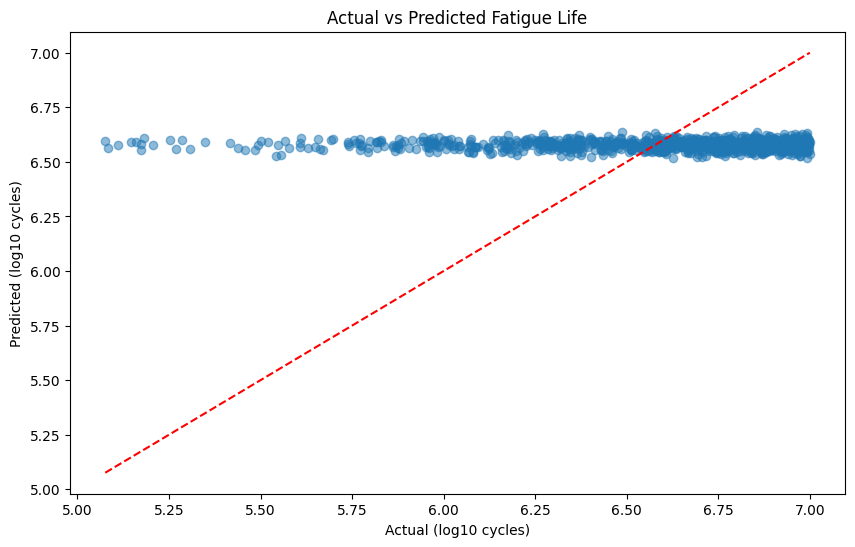


Generating model explanations...


<ipython-input-42-75d4ec841d07>:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, plot_type='bar')


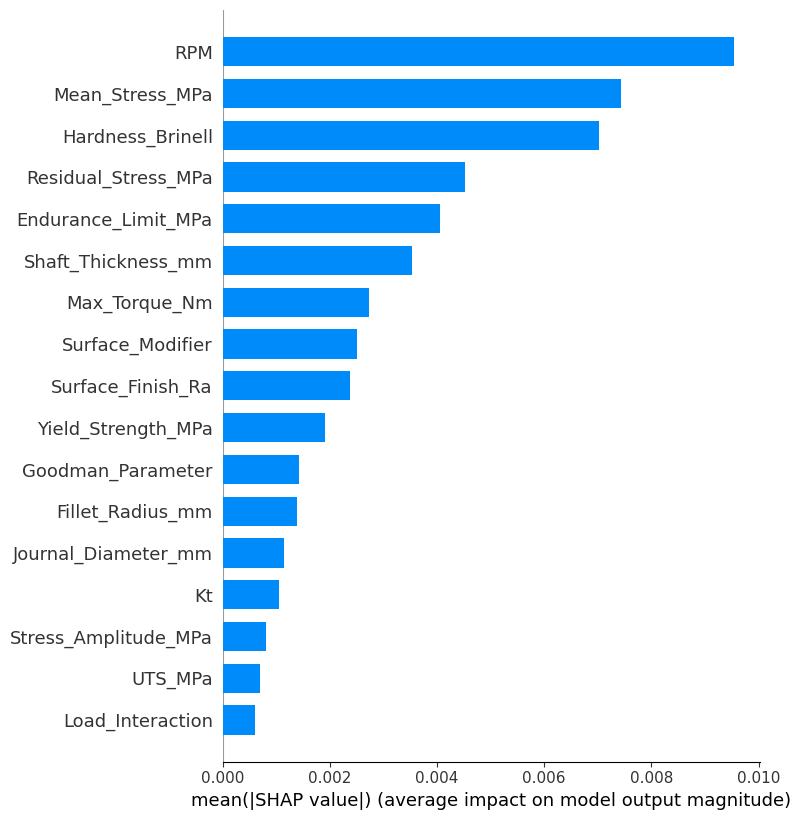

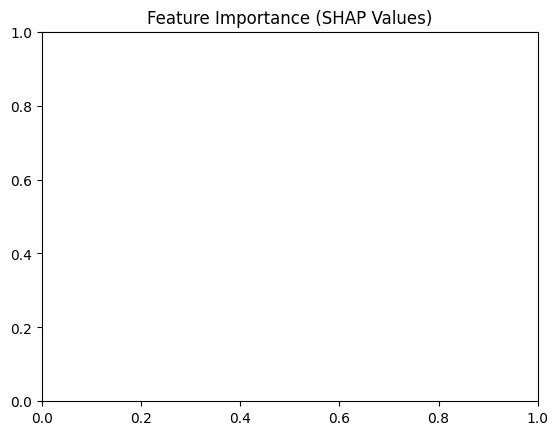

['crankshaft_fatigue_model.pkl']

In [53]:
df = generate_synthetic_data()
df = add_engineered_features(df)
X = df.drop('Fatigue_Life_Cycles', axis=1)
y = np.log10(df['Fatigue_Life_Cycles'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
print("Training initial model...")
model = train_xgboost_model(X_train_scaled, y_train)
evaluate_model(model, X_test_scaled, y_test)
print("\nOptimizing hyperparameters...")
best_params = optimize_hyperparameters(X_train_scaled, y_train)
print(f"Best parameters: {best_params}")
print("\nTraining final model...")
final_model = xgb.XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist'
)
final_model.fit(X_train_scaled, y_train)
evaluate_model(final_model, X_test_scaled, y_test)
print("\nGenerating model explanations...")
explain_model(final_model, X_train_scaled)
import joblib
joblib.dump({
    'model': final_model,
    'scaler': scaler,
    'features': X.columns.tolist()
}, 'crankshaft_fatigue_model.pkl')